In [1]:
%pylab inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import data

In [3]:
koubei = data.koubei()

In [4]:
taobao = data.taobao()

In [5]:
tk = taobao[taobao.user_id.isin(koubei.user_id)]

In [7]:
tk.head()

,user_id,seller_id,item_id,category_id,action_id,timestamp
7,1652831,589,1533782,1,0,20150702
9,43130,4058,1745953,1,0,20151019
23,1651174,4058,1745953,1,0,20151010
33,1622079,4058,1745953,1,0,20151002
46,43130,4058,1745953,1,0,20151019


In [9]:
print('总的类别的数目：%d' % tk.category_id.nunique())
print('口碑与淘宝链接后的类别数目：%d'% taobao.category_id.nunique())

总的类别的数目：72
口碑与淘宝链接后的类别数目：72


与地理位置密切相关的商品类别

In [10]:
hotcat = tk.groupby('category_id').size()

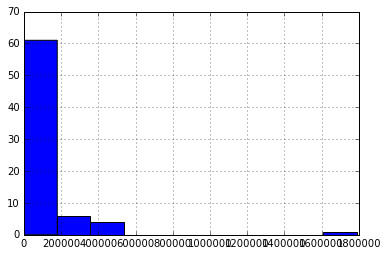

In [11]:
hotcat.hist();

In [12]:
len(hotcat[hotcat.rank() > 20])

52

In [42]:
hotk = tk[tk.category_id.isin(hotcat[hotcat.rank() > 40].index)].groupby(['user_id', 'category_id']).agg(dict(action_id=len))

In [43]:
hotk.head()

action_id
user_id category_id           
4       1                    1
        10                   2
        18                   1
        34                   1
        42                   1

In [44]:
hotkc = hotk.reset_index().pivot('user_id', 'category_id', 'action_id').fillna(0)

In [45]:
hotkc.head()

category_id,1,2,10,15,16,17,18,20,21,24,...,57,58,60,61,62,63,66,68,69,70
user_id,,,,,,,,,,,,,,,,,,,,,
4,1,0,2,0,0,0,1,0,0,0,...,1,0,2,0,0,0,0,0,0,2
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,6,0,4,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
89,5,0,24,2,0,0,6,0,22,0,...,1,0,0,19,4,3,2,0,0,0
97,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
hotkc.shape

(179423, 32)

--------

In [6]:
pred = pd.read_csv('data/ijcai2016_koubei_test', header=None, names=['user_id', 'location_id'])

In [47]:
tp = taobao[taobao.user_id.isin(pred.user_id)]

In [49]:
tp.head()

,user_id,seller_id,item_id,category_id,action_id,timestamp
0,1980536,9666,1450952,1,0,20150826
1,1980536,9666,1450952,1,0,20150826
3,1980536,9666,1450952,1,0,20150823
4,183647,9525,578730,1,0,20150711
5,723956,589,28301,1,0,20150825


In [50]:
hotp = tp[tp.category_id.isin(hotcat[hotcat.rank() > 40].index)].groupby(['user_id', 'category_id']).agg(dict(action_id=len))

In [51]:
hotp.head()

action_id
user_id category_id           
5       45                   1
17      1                    1
23      1                   13
        34                   5
        55                   4

In [52]:
hotpc = hotp.reset_index().pivot('user_id', 'category_id', 'action_id').fillna(0)

In [53]:
hotpc.head()

category_id,1,2,10,15,16,17,18,20,21,24,...,57,58,60,61,62,63,66,68,69,70
user_id,,,,,,,,,,,,,,,,,,,,,
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,13,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,7,0
24,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0


In [54]:
hotpc.shape

(358123, 32)

-----------

建立邻域搜索模型

In [56]:
from sklearn import neighbors

In [57]:
knn = neighbors.NearestNeighbors(n_jobs=-1, n_neighbors=10, algorithm='auto')

In [58]:
cols = hotkc.columns

In [59]:
X = hotkc.as_matrix(cols)

In [60]:
P = hotpc.as_matrix(cols)

In [62]:
knn.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=-1, n_neighbors=10, p=2, radius=1.0)

In [63]:
nidx = knn.kneighbors(P, return_distance=False)

In [73]:
nidx = nidx[1] # only use when return_distance is False.

In [65]:
XU = hotkc.index

In [66]:
PU = hotpc.index

In [69]:
XU[0]

4

In [70]:
PU[0]

5

In [74]:
simdf = pd.DataFrame.from_records([(PU[i], XU[j]) for i, r in enumerate(nidx) for j in r], columns=['user_id', 'sim_user_id'])

In [75]:
simdf.set_index('user_id').to_csv('data/simdf_0430.csv')

In [76]:
simdf.head()

,user_id,sim_user_id
0,5,359
1,5,57799
2,5,29285
3,5,54852
4,5,21919


---------

连接相似的用户访问过的商店和地点

In [85]:
simmer = pd.merge(
    simdf,
    koubei[['user_id', 'location_id', 'merchant_id']].drop_duplicates().set_index('user_id'),
    left_on='sim_user_id', right_index=True, how='left'
)

In [86]:
simmer.head()

,user_id,sim_user_id,location_id,merchant_id
0,5,359,172,820
0,5,359,172,2606
1,5,57799,441,4234
2,5,29285,188,334
3,5,54852,84,1978


In [103]:
ums = simmer.groupby(['user_id', 'merchant_id']).sim_user_id.nunique().reset_index()
ums.rename(columns={'sim_user_id': 'sim_users'}, inplace=True)

In [104]:
ums.head()

,user_id,merchant_id,sim_users
0,5,334,1
1,5,820,2
2,5,1978,1
3,5,2001,1
4,5,2340,1


In [92]:
ums.set_index('user_id').to_csv('data/user_catsim_merchant.csv')

---------------

地理位置附近的（关联的）商家，以及根据用户相似度找到的对商家的支持度。

In [98]:
lm = koubei.groupby(['location_id', 'merchant_id']).user_id.nunique().reset_index()
lm.rename(columns={'user_id': 'merchant_users'}, inplace=True)

In [99]:
lm.head()

,location_id,merchant_id,merchant_users
0,1,1225,2
1,1,3222,3
2,1,3780,2
3,1,4417,3
4,1,7547,2


In [101]:
plm = pd.merge(pred, lm, on='location_id', how='left')

In [102]:
plm.head()

,user_id,location_id,merchant_id,merchant_users
0,753792,112,161,35
1,753792,112,571,80
2,753792,112,670,1
3,753792,112,704,12
4,753792,112,820,684


In [105]:
plums = pd.merge(plm, ums, on=['user_id', 'merchant_id'], how='left')

In [106]:
plums.head()

,user_id,location_id,merchant_id,merchant_users,sim_users
0,753792,112,161,35,NaN
1,753792,112,571,80,NaN
2,753792,112,670,1,NaN
3,753792,112,704,12,NaN
4,753792,112,820,684,NaN


In [109]:
count_nonzero(plums[~plums.user_id.isin(koubei.user_id)].sim_users)

18353776

In [112]:
nk = plums[~plums.user_id.isin(koubei.user_id)].dropna()

In [114]:
nk['sim_users_rank'] = nk.groupby(['user_id', 'location_id']).sim_users.rank()

In [115]:
nk.head()

,user_id,location_id,merchant_id,merchant_users,sim_users,sim_users_rank
387,1279360,254,5231,1406,4,1.0
439,296576,253,8817,82,1,1.0
539,362624,265,820,622,1,1.5
553,362624,265,5231,429,1,1.5
730,1543040,134,4264,65,1,1.0


In [116]:
nkm = nk[nk.sim_users_rank < 3]

In [117]:
rec = pd.concat([
    pd.merge(pred, koubei[['user_id', 'location_id', 'merchant_id']].drop_duplicates(), on=['user_id', 'location_id'], how='inner'),
    nkm[['user_id', 'location_id', 'merchant_id']]
])

In [118]:
rec.head()

,user_id,location_id,merchant_id
0,427392,172,820
1,427392,172,4796
2,427392,172,5231
3,1934976,8,9968
4,560512,337,2943


In [121]:
s = rec.groupby(['user_id', 'location_id']).merchant_id.agg(lambda d: ':'.join(str(int(i)) for i in d))

In [122]:
s.head()

user_id  location_id
5        371                5231
17       11                 8817
32       190            820:2606
42       337                 820
48       461            820:5231
Name: merchant_id, dtype: object

In [124]:
s.to_csv('submit/0430.csv')